In [1]:
import utils
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [2]:
data = "B05" # [B05, B06, B07, B18]

In [3]:
cycle = 30

In [4]:
LSTM_model = tf.keras.models.load_model("model/LSTM/")
TFM_model = tf.keras.models.load_model("model/Transformer+T2V/")

In [5]:
dataDict = {
    "B05" : 0,
    "B06" : 1,
    "B07" : 2,
    "B18" : 3,
}

In [6]:
dataPath = "data/NASA/"
x_test, y_test = utils.getData(dataPath)

In [7]:
testX, testY, SS_tt = utils.extract_VIT_capacity([x_test[dataDict[data]]], [y_test[dataDict[data]]], 5, 1, 10) # extract_VIT_capacity(test_x_data, test_y_data, 5, 1, 10)

In [8]:
LSTM_testPredict = LSTM_model.predict(testX)
TFM_testPredict = TFM_model.predict(testX)

In [9]:
# test_loss = []
# results = model.evaluate(testX, testY)
# test_loss.append(results)
# print('Test loss:', results)

In [10]:
inv_testY = SS_tt[0][30].inverse_transform(testY)
LSTM_inv_testPredict = SS_tt[0][30].inverse_transform(LSTM_testPredict)
TFM_inv_testPredict = SS_tt[0][30].inverse_transform(TFM_testPredict)

In [11]:
def plot_pred(LSTM_predict=None, TFM_predict=None, true=None, save_dir=None, cycle=None):

    # Threshold
    threshold = np.empty((len(LSTM_predict)))
    #   th_init = predict[0]*0.7 # threshold 70% dari kapasitas awal
    threshold.fill(1.4)


    fig = plt.figure(figsize=(12, 4), dpi=150)

    # Data LSTM Predict
    LSTM_predict = LSTM_predict.reshape(LSTM_predict.shape[0])
    x = range(len(LSTM_predict))
    f = threshold
    g = LSTM_predict.flatten()

    # Data TFM Predict
    TFM_predict = TFM_predict.reshape(TFM_predict.shape[0])
    TFM_x = range(len(TFM_predict))
    TFM_g = TFM_predict.flatten()

    # Data True
    true = true.reshape(true.shape[0])
    x_true = range(len(true))
    tr = true.flatten()

    try:
        idx_LSTM = np.argwhere(np.isclose(f, g, atol=0.01)).flatten()  # Titik potong LSTM
        idx_TFM = np.argwhere(np.isclose(f, TFM_g, atol=0.01)).flatten() # Titik potong TFM
        idx_true = np.argwhere(np.isclose(f, tr, atol=0.01)).flatten()  # Titik potong True
        
        # Plot EOL Boundary
        plt.axvline(idx_LSTM[0] - cycle, color='g', ls='--', label="RUL")
        plt.axvline(idx_true[-1], color='g', ls='--')
        plt.plot(x[idx_LSTM[0] - cycle - 30:], f[idx_LSTM[0] - cycle - 30:], 'k-.', label='Threshold')  # plot threshold
        
        plt.plot(x_true[idx_LSTM[0] - cycle - 30:], tr[idx_LSTM[0] - cycle - 30:], 'r',label='True')  # plot True        
        plt.plot(x[idx_LSTM[0] - cycle:idx_true[-1] + 1], g[idx_LSTM[0] - cycle:idx_true[-1] + 1], 'g-',
                 label='LSTM')  # plot prediction LSTM
        plt.plot(TFM_x[idx_LSTM[0]- cycle:idx_true[-1] + 1], TFM_g[idx_LSTM[0]- cycle:idx_true[-1] + 1], 'b-',
                 label="Transformer") # plot prediction Transformer
        
        text = '\n'.join((
                f"EOL LSTM: {idx_LSTM[-1]}",
                f"EOL Transformer: {idx_TFM[-1]}",
                f"EOL True: {idx_true[-1]}",
                f"Error LSTM: {abs(idx_true[-1] - idx_LSTM[-1])}",
                f"Error Transformer: {abs(idx_true[-1] - idx_TFM[-1])}"
            ))
        
        box = dict(boxstyle='square', facecolor='wheat', alpha=0.5)
        
#         plt.text(x[idx_true[-1] - 45], g[np.where(g == LSTM_predict[50])], text, bbox=box)
        plt.gcf().text(0.7, 0.6, text, bbox=box)
        plt.gcf().text(0.2, 0.8, "Starting Cycle")
        
#         plt.text(x[idx_LSTM[0] - cycle - 20], g[np.where(g == LSTM_predict[30])], "Starting Cycle")
#         plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[50])], f"EOL LSTM: {idx_LSTM[-1]}")
#         plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[55])], f"EOL Transformer: {idx_TFM[-1]}")
#         plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[60])], f"EOL True: {idx_true[-1]}")
#         plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[70])], f"Error: {abs(idx_true[-1] - idx_LSTM[-1])}")

    except Exception as e:
        plt.plot(x, f, 'k-.', label="Threshold")
        plt.plot(true, label='True')
        
        plt.axvline(idx_true[-1], color='g', ls='--')
        
        plt.text(x[-1] - 33, g[0] - 0.09, "EOL LSTM: NaN")
        plt.text(x[-1] - 33, g[0] - 0.12, "EOL Transformer: NaN")
        plt.text(x[-1] - 33, g[0] - 0.15, f"EOL True: {idx_true[-1]}")
        plt.text(x[-1] - 33, g[0] - 0.2, "Error: NaN")

    plt.xlabel('Number of Cycle', fontsize=13)
    plt.ylabel('Discharge Capacity (Ah)', fontsize=13)
#     plt.legend(loc='upper right', fontsize=12)
    plt.legend(loc='center right', bbox_to_anchor=(1.17, 0.5))

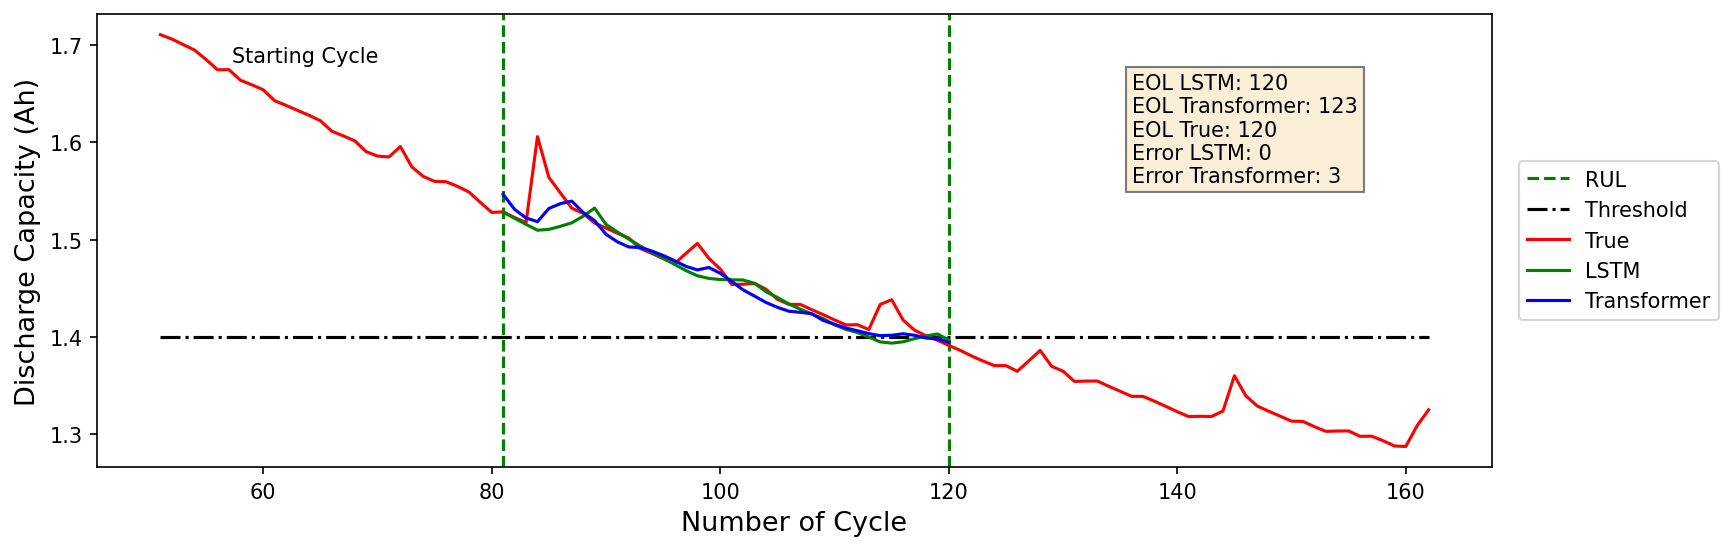

In [12]:
plot_pred(LSTM_inv_testPredict, TFM_inv_testPredict,inv_testY, cycle=cycle)

In [13]:
# def plot_pred(predict=None, true=None, save_dir=None, cycle=None): 
    
#     threshold = np.empty((len(predict)))
# #   th_init = predict[0]*0.7 # threshold 70% dari kapasitas awal
#     threshold.fill(1.4)
#     predict = predict.reshape(predict.shape[0])
        
#     fig=plt.figure(figsize=(12, 4),dpi=150)
    
#     # Data Predict
#     x = range(len(predict))
#     f = threshold
#     g = predict.flatten()
    
#     # Data True
#     true = true.reshape(true.shape[0])
#     x_true = range(len(true))
#     tr = true.flatten()
    
#     try: 
#         idx = np.argwhere(np.isclose(f, g, atol=0.01)).flatten() # Titik potong Predict
#         idx_true = np.argwhere(np.isclose(f, tr, atol=0.01)).flatten() # Titik potong True
        
#     except Exception as e:
#         pass
    
# #     idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    
# #     plt.plot(x[idx[0]-cycle-30:], f[idx[0]-cycle-30:], 'r-.') # plot threshold    
#     # plot threshold    
    
#     try:
#         plt.plot(x[idx[0]-cycle-30:], f[idx[0]-cycle-30:], 'r-.') # plot threshold    
#         plt.plot(x[idx[0]-cycle:idx_true[-1]+1], g[idx[0]-cycle:idx_true[-1]+1], '-', label='Prediction') # plot prediction
#         plt.plot(x_true[idx[0]-cycle-30:], tr[idx[0]-cycle-30:] ,label='True') # plot True
        
#     except Exception as e:
#         plt.plot(x, f, 'r-.', label="Threshold") 
#         plt.plot(true,label='True')
#         pass
    
# #     plt.plot(x[idx[0]-cycle:idx[0]+endCycle], g[idx[0]-cycle:idx[0]+endCycle], '-', label='Prediction') # plot prediction
    
    
#     try:
#         # Plot EOL Boundary
#         y1_boundary = np.empty(len(x))
#         y1_boundary_fill = x[idx[0]-cycle]
#         y1_boundary.fill(y1_boundary_fill)
#         plt.plot(y1_boundary, predict, 'g-.')

#         y2_boundary = np.empty(len(x))
#         y2_boundary_fill = x[idx_true[-1]]
#         y2_boundary.fill(y2_boundary_fill)
#         plt.plot(y2_boundary, predict, 'g-.')
        
#     except Exception as e:
#         y1_boundary = np.empty(len(x))
#         y1_boundary_fill = x[-1]
#         y1_boundary.fill(y1_boundary_fill)
#         plt.plot(y1_boundary, predict, 'g-.')
    
    
#     plt.text(x[idx[0]-cycle-20], g[0], "Starting Cycle")
    
#     try:
#         plt.text(x[idx[0]-cycle-20], g[0], "Starting Cycle")
# #         plt.annotate("Starting Cycle",
# #                  xy=(x[idx[0]-cycle-20], g[0]),
# #                  xytext=(x[idx[0]-cycle-20], g[0]))

#         plt.text(x[idx_true[-1]-20], g[int(len(g)/3.4)], f"EOL Predict: {idx[-1]}")
# #         plt.annotate(f"EOL Predict: {idx[-1]}",
# #                  xy=(x[idx_true[-1]-20], g[int(len(g)/3.4)]),
# #                  xytext=(x[idx_true[-1]-20], g[int(len(g)/3.4)]))

#         plt.text(x[idx_true[-1]-20], g[int(len(g)/3.)], f"EOL True: {idx_true[-1]}")
# #         plt.annotate(f"EOL True: {idx_true[-1]}",
# #              xy=(x[idx_true[-1]-20], g[int(len(g)/3.)]),
# #              xytext=(x[idx_true[-1]-20], g[int(len(g)/3.)]))

#         plt.text(x[idx_true[-1]-20], g[int(len(g)/2.5)], f"Error: {abs(idx_true[-1]-idx[-1])}")
# #         plt.annotate(f"Error: {abs(idx_true[-1]-idx[-1])}",
# #              xy=(x[idx_true[-1]-20], g[int(len(g)/2.5)]),
# #              xytext=(x[idx_true[-1]-20], g[int(len(g)/2.5)]))
#     except Exception as e:
#         plt.text(x[-1]-33, g[0]-0.9, "Starting Cycle")
# #         plt.annotate("Starting Cycle",
# #                  xy=(x[-1]-33, g[0]-0.9),
# #                  xytext=(x[-1]-33, g[0]-0.9))

#         plt.text(x[-1]-30, g[0]-0.1, "EOL Predict: NaN")
# #         plt.annotate(f"EOL Predict: {np.nan}",
# #                  xy=(x[-1]-30, g[0]-0.1),
# #                  xytext=(x[-1]-30, g[0]-0.1))

#         plt.text(x[-1]-30, g[0]-0.15, "EOL True: NaN")
# #         plt.annotate(f"EOL True: {np.nan}",
# #                      xy=(x[-1]-30, g[0]-0.15),
# #                      xytext=(x[-1]-30, g[0]-0.15))

#         plt.text(x[-1]-30, g[0]-0.2, "Error: NaN")
# #         plt.annotate(f"Error: {np.nan}",
# #                      xy=(x[-1]-30, g[0]-0.2),
# #                      xytext=(x[-1]-30, g[0]-0.2))
    
        
#     plt.xlabel('Number of Cycle',fontsize=13)
#     plt.ylabel('Discharge Capacity (Ah)',fontsize=13)
#     plt.legend(loc='upper right',fontsize=12)
#     # plt.title(str(model_name.__name__)+' Prediction of Discharge Capacity of Test Data (B0005)',fontsize=14)
#     #plt.legend(loc='upper right',fontsize=12)
# #     plt.savefig(os.path.join(save_dir, model_dir, name+'.png'))

In [42]:
def plot_pred(LSTM_predict=None, TFM_predict=None, true=None, save_dir=None, cycle=None):

    # Threshold
    threshold = np.empty((len(LSTM_predict)))
    #   th_init = predict[0]*0.7 # threshold 70% dari kapasitas awal
    threshold.fill(1.4)


    fig = plt.figure(figsize=(12, 4), dpi=150)

    # Data LSTM Predict
    LSTM_predict = LSTM_predict.reshape(LSTM_predict.shape[0])
    x = range(len(LSTM_predict))
    f = threshold
    g = LSTM_predict.flatten()

    # Data TFM Predict
    TFM_predict = TFM_predict.reshape(TFM_predict.shape[0])
    TFM_x = range(len(TFM_predict))
    TFM_g = TFM_predict.flatten()

    # Data True
    true = true.reshape(true.shape[0])
    x_true = range(len(true))
    tr = true.flatten()

    try:
        idx_LSTM = np.argwhere(np.isclose(f, g, atol=0.01)).flatten()  # Titik potong LSTM
        idx_TFM = np.argwhere(np.isclose(f, TFM_g, atol=0.01)).flatten() # Titik potong TFM
        idx_true = np.argwhere(np.isclose(f, tr, atol=0.01)).flatten()  # Titik potong True
        
        plt.plot(x_true[idx_LSTM[0] - cycle - 30:], tr[idx_LSTM[0] - cycle - 30:], 'r',label='True')  # plot True
        plt.plot(x[idx_LSTM[0] - cycle - 30:], f[idx_LSTM[0] - cycle - 30:], 'k-.', label='Threshold')  # plot threshold
        plt.plot(x[idx_LSTM[0] - cycle:idx_true[-1] + 1], g[idx_LSTM[0] - cycle:idx_true[-1] + 1], 'g-',
                 label='LSTM')  # plot prediction LSTM
        plt.plot(TFM_x[idx_LSTM[0]- cycle:idx_true[-1] + 1], TFM_g[idx_LSTM[0]- cycle:idx_true[-1] + 1], 'b-',
                 label="Transformer") # plot prediction Transformer
        
        # Plot EOL Boundary
        x1_boundary = np.empty(len(x))
        x1_boundary_fill = x[idx_LSTM[0] - cycle]
        x1_boundary.fill(x1_boundary_fill)
        plt.plot(x1_boundary, LSTM_predict, 'g-.', label="RUL")

        x2_boundary = np.empty(len(x))
        x2_boundary_fill = x[idx_true[-1]]
        x2_boundary.fill(x2_boundary_fill)
        plt.plot(x2_boundary, LSTM_predict, 'g-.')
        
        plt.text(x[idx_LSTM[0] - cycle - 20], g[0], "Starting Cycle")
        plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[50])], f"EOL LSTM: {idx_LSTM[-1]}")
        plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[55])], f"EOL Transformer: {idx_TFM[-1]}")
        plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[60])], f"EOL True: {idx_true[-1]}")
        plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[70])], f"Error: {abs(idx_true[-1] - idx_LSTM[-1])}")

    except Exception as e:
        plt.plot(x, f, 'k-.', label="Threshold")
        plt.plot(true, label='True')
        
        x1_boundary = np.empty(len(x))
        x1_boundary_fill = x[idx_true[-1]]
        x1_boundary.fill(x1_boundary_fill)
        plt.plot(x1_boundary, LSTM_predict, 'g-.', label="RUL")
        
        plt.text(x[-1] - 33, g[0] - 0.09, "EOL LSTM: NaN")
        plt.text(x[-1] - 33, g[0] - 0.12, "EOL Transformer: NaN")
        plt.text(x[-1] - 33, g[0] - 0.15, f"EOL True: {idx_true[-1]}")
        plt.text(x[-1] - 33, g[0] - 0.2, "Error: NaN")

#     try:
#         plt.plot(x_true[idx_LSTM[0] - cycle - 30:], tr[idx_LSTM[0] - cycle - 30:], 'r',label='True')  # plot True
#         plt.plot(x[idx_LSTM[0] - cycle - 30:], f[idx_LSTM[0] - cycle - 30:], 'k-.', label='Threshold')  # plot threshold
#         plt.plot(x[idx_LSTM[0] - cycle:idx_true[-1] + 1], g[idx_LSTM[0] - cycle:idx_true[-1] + 1], 'g-',
#                  label='LSTM')  # plot prediction LSTM
#         plt.plot(TFM_x[idx_LSTM[0]- cycle:idx_true[-1] + 1], TFM_g[idx_LSTM[0]- cycle:idx_true[-1] + 1], 'b-',
#                  label="Transformer") # plot prediction Transformer

#     except Exception as e:
#         plt.plot(x, f, 'k-.', label="Threshold")
#         plt.plot(true, label='True')
#         pass

#     try:
#         # Plot EOL Boundary
#         x1_boundary = np.empty(len(x))
#         x1_boundary_fill = x[idx_LSTM[0] - cycle]
#         x1_boundary.fill(x1_boundary_fill)
#         plt.plot(x1_boundary, LSTM_predict, 'g-.', label="RUL")

#         x2_boundary = np.empty(len(x))
#         x2_boundary_fill = x[idx_true[-1]]
#         x2_boundary.fill(x2_boundary_fill)
#         plt.plot(x2_boundary, LSTM_predict, 'g-.')

#     except Exception as e:
#         x1_boundary = np.empty(len(x))
#         x1_boundary_fill = x[idx_true[-1]]
#         x1_boundary.fill(x1_boundary_fill)
#         plt.plot(x1_boundary, LSTM_predict, 'g-.', label="RUL")
        
#     try:
#         plt.text(x[idx_LSTM[0] - cycle - 20], g[0], "Starting Cycle")
#         plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[50])], f"EOL LSTM: {idx_LSTM[-1]}")
#         plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[55])], f"EOL Transformer: {idx_TFM[-1]}")
#         plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[60])], f"EOL True: {idx_true[-1]}")
#         plt.text(x[idx_true[-1] - 20], g[np.where(g == LSTM_predict[70])], f"Error: {abs(idx_true[-1] - idx_LSTM[-1])}")
        
#     except Exception as e:
# #         plt.text(x[-1] - 33, g[0] - 0.02, "Starting Cycle")
#         plt.text(x[-1] - 33, g[0] - 0.09, "EOL LSTM: NaN")
#         plt.text(x[-1] - 33, g[0] - 0.12, "EOL Transformer: NaN")
#         plt.text(x[-1] - 33, g[0] - 0.15, f"EOL True: {idx_true[-1]}")
#         plt.text(x[-1] - 33, g[0] - 0.2, "Error: NaN")

    plt.xlabel('Number of Cycle', fontsize=13)
    plt.ylabel('Discharge Capacity (Ah)', fontsize=13)
#     plt.legend(loc='upper right', fontsize=12)
    plt.legend()

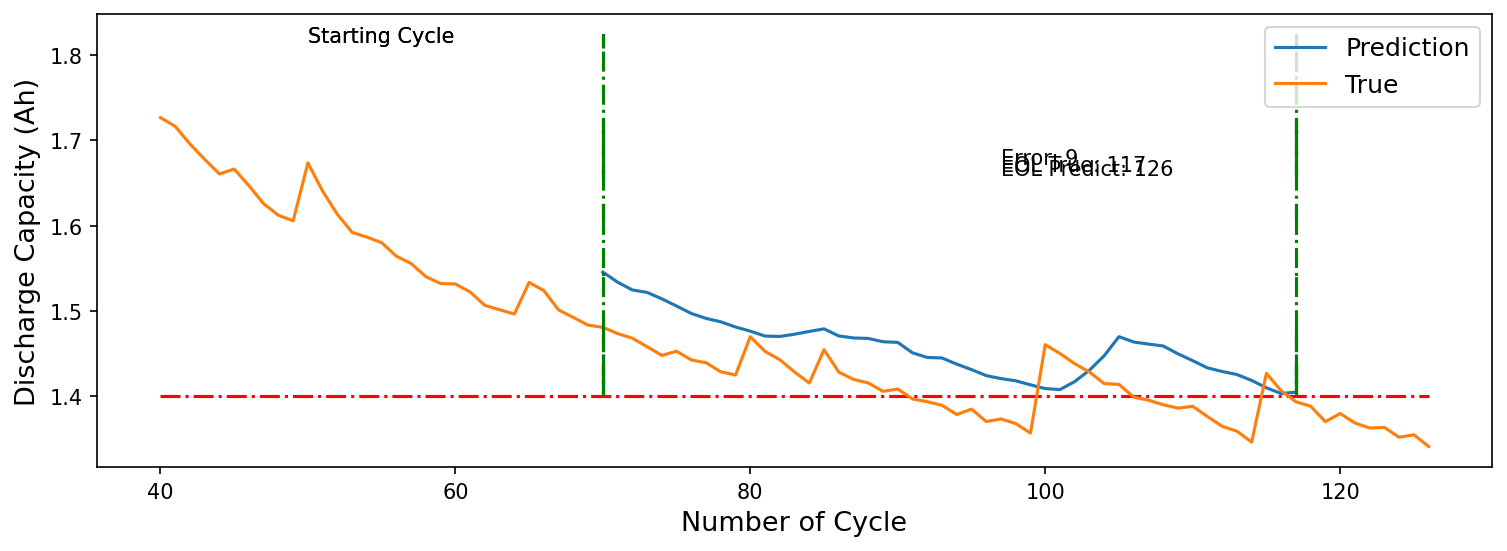

In [14]:
plot_pred(LSTM_inv_testPredict,inv_testY, cycle=cycle)

In [15]:
# def plot_pred(predict=None, save_dir=None, cycle=None, endCycle = 10): 
    
#     threshold = np.empty((len(predict))) 
#     threshold.fill(1.4)
#     predict = predict.reshape(predict.shape[0])
        
#     fig=plt.figure(figsize=(12, 4),dpi=150)
    
#     x = range(len(predict))
#     f = threshold
#     g = predict.flatten()
    
#     idx = np.argwhere(np.isclose(f, g, atol=0.001)).flatten()
# #     idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    
#     # titik potong menjadi titik awal
# #     plt.plot(x[idx[0]:-cycle], f[idx[0]:-cycle], 'r-.')
# #     plt.plot(x[idx[0]:-cycle], g[idx[0]:-cycle], '-')
    
#     # titik potong menjadi titik akhir
#     plt.plot(x[idx[0]-cycle:idx[0]+endCycle], f[idx[0]-cycle:idx[0]+endCycle], 'r-.')
#     plt.plot(x[idx[0]-cycle:idx[0]+endCycle], g[idx[0]-cycle:idx[0]+endCycle], '-')
    
#     plt.annotate(f"Critical Point, Cycle {idx[0]}",
#              xy=(x[idx[0]], f[idx[0]]),
#              xytext=(x[idx[0]], 1.03*f[idx[0]]),
#             arrowprops={})
        
#     plt.xlabel('Number of Cycle',fontsize=13)
#     plt.ylabel('DIscharge Capacity (Ah)',fontsize=13)
#     # plt.title(str(model_name.__name__)+' Prediction of Discharge Capacity of Test Data (B0005)',fontsize=14)
#     #plt.legend(loc='upper right',fontsize=12)
# #     plt.savefig(os.path.join(save_dir, model_dir, name+'.png'))

In [16]:
def plotpred(predict, true, save_dir, model_dir, name):    # Plot test prediction
    predict = predict.reshape(predict.shape[0])
    true = true.reshape(true.shape[0])
    fig=plt.figure(figsize=(12, 4),dpi=150)
    plt.plot(predict,label='Prediction')
    plt.plot(true,label='True')
    plt.xlabel('Number of Cycle',fontsize=13)
    plt.ylabel('DIscharge Capacity (Ah)',fontsize=13)
    # plt.title(str(model_name.__name__)+' Prediction of Discharge Capacity of Test Data (B0005)',fontsize=14)
    plt.legend(loc='upper right',fontsize=12)
#     plt.savefig(os.path.join(save_dir, model_dir, name+'.png'))

In [17]:
plotpred(inv_testPredict, inv_testY, None, None,name='test_pred')

NameError: name 'inv_testPredict' is not defined

# coba anotasi

In [ ]:
predict = inv_testPredict
threshold = np.empty((len(predict))) 
threshold.fill(1.4)
predict = predict.reshape(predict.shape[0])

fig=plt.figure(figsize=(12, 4),dpi=150)

x = range(len(predict))
f = threshold
g = predict.flatten()

# idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
idx = np.argwhere(np.isclose(f, g, atol=0.001)).flatten()

# titik potong menjadi titik awal
#     plt.plot(x[idx[0]:-cycle], f[idx[0]:-cycle], 'r-.')
#     plt.plot(x[idx[0]:-cycle], g[idx[0]:-cycle], '-')

# titik potong menjadi titik akhir
plt.plot(x[idx[0]-cycle:idx[0]+3], f[idx[0]-cycle:idx[0]+3], 'r-.')
plt.plot(x[idx[0]-cycle:idx[0]+3], g[idx[0]-cycle:idx[0]+3], '-')

plt.xlabel('Number of Cycle',fontsize=13)
plt.ylabel('DIscharge Capacity (Ah)',fontsize=13)

plt.annotate(f"Critical Point, Cycle {idx[0]}",
             xy=(x[idx[0]], f[idx[0]]),
             xytext=(x[idx[0]]-1, 1.02*f[idx[0]]),
            arrowprops={})

In [ ]:
def cek():
    global aaa
    aaa = 5

In [ ]:
cek()

In [ ]:
aaa

In [ ]:
y = [1,2,3,4,5,6,7,8]
x = [3,3,3,3,3,3,3,3]
xx = [1,2,3,4,5,6,7,8]

In [ ]:
yy = np.empty(len(y))
yy.fill(3)
yy

In [ ]:
plt.plot(x,y)
plt.plot(xx,y)

In [ ]:
"""TODO:
1. Merapikan anotasi
2. Merapikan GUI (clear canvas)
3. Menggabungkan plot model transformer+T2V
4. Memberikan keterangan N/A pada EOL B07
5. Meletakkan garis EOL B07 di ujung kanan
"""